In [67]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import numpy as np
import torchdata.datapipes as dp
import boto3
import os
import skimage
import PIL.Image
import json
import fsspec

In [2]:
def download_from_s3(bucket: str, remote_path: str, local_path: str, s3_client=None):
    if not s3_client:
        s3_client = boto3.client("s3")
    s3_client.download_file(bucket, remote_path, local_path)


def split_bucket_from_path(x: str):
    return "".join(x.split("/")[2:3]), "/".join(x.split("/")[3:])


def combine_bands(arrays: list[np.array], max_res=(120, 120)):
    """Combines bands into one array, upscaling each band to max_res.

    Args:
        arrays (list): list of bands
        max_res (tuple, optional): Max height & width to resize bands to. Defaults to (120, 120).

    Returns:
        np.array: Concatenated & resized bands.
    """
    result = np.zeros(shape=(*max_res, len(arrays)))
    for i, array in enumerate(arrays):
        assert array.shape[0] <= max_res[0]
        assert array.shape[1] <= max_res[1]
        result[:, :, i] = cv2.resize(array, dsize=max_res)
    return result


def get_first_n_pcs(img: np.array, num_components: int):
    """Perform PCA on a single image and return principle components which make up the most variance.

    Args:
        img (np.array): Original image of shape (h, w, num_bands).
        num_components (int): Desired number of components to be returned.

    Returns:
        np.array: Components with shape (h, w, num_components).
    """
    # Convert 2d bands into 1-d arrays
    bands_vectorized = np.zeros(
        shape=(resized.shape[0] * resized.shape[1], resized.shape[2])
    )
    for i in range(img.shape[-1]):
        flattened_band = img[:, :, i].flatten()
        flattened_band_standard = (
            flattened_band - flattened_band.mean()
        ) / flattened_band.std()
        bands_vectorized[:, i] = flattened_band_standard

    cov = np.cov(bands_vectorized.transpose())
    eig_val, eig_vec = np.linalg.eig(cov)

    # Ordering Eigen values and vectors
    order = eig_val.argsort()[::-1]
    eig_val = eig_val[order]
    eig_vec = eig_vec[:, order]

    # Projecting data on Eigen vector directions resulting in Principal Components
    pcs = np.matmul(bands_vectorized, eig_vec)

    # Rearranging 1-d arrays to 2-d arrays of image size
    PC_2d = np.zeros((img.shape[0], img.shape[1], num_components))
    for i in range(num_components):
        PC_2d[:, :, i] = pcs[:, i].reshape(-1, img.shape[1])

    # normalizing between 0 to 255
    PC_2d_Norm = np.zeros((img.shape[0], img.shape[1], num_components))
    for i in range(num_components):
        PC_2d_Norm[:, :, i] = cv2.normalize(
            PC_2d[:, :, i], np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX
        )

    # fig,axes = plt.subplots(3,4,figsize=(50,23),sharex='all',
    #                         sharey='all')
    # fig.subplots_adjust(wspace=0.1, hspace=0.15)
    # fig.suptitle('Intensities of Principal Components ', fontsize=30)

    # axes = axes.ravel()
    # for i in range(num_components):
    #     axes[i].imshow(PC_2d_Norm[:,:,i],cmap='gray', vmin=0, vmax=255)
    #     axes[i].set_title('PC '+str(i+1),fontsize=25)
    #     axes[i].axis('off')
    # fig.delaxes(axes[-1])
    return PC_2d_Norm[:, :, : num_components + 1]

In [3]:
folder = "S2A_MSIL2A_20170613T101031_14_65/"
bucketname = f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"
pipe = dp.iter.IterableWrapper([bucketname])
pipe = pipe.list_files_by_fsspec()

In [4]:
tifs = [x for x in pipe if ".tif" in x]
for tif in tifs:
    bucket, remote = split_bucket_from_path(tif)
    file = tif.split("/")[-1]
    if not os.path.isdir(
        f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
    ):
        os.mkdir(
            f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
        )
    local = (
        f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
        + file
    )
    download_from_s3(bucket=bucket, remote_path=remote, local_path=local)

In [5]:
tif_dir = f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
local_tifs = [os.path.join(tif_dir, x) for x in os.listdir(tif_dir)]
imgs = [skimage.io.imread(path) for path in local_tifs]
bands = [tif.split("_")[-1].split(".")[0] for tif in local_tifs]
resized = combine_bands(imgs)

In [6]:
top_pipe = dp.iter.IterableWrapper([f"s3://mi4people-soil-project/BigEarthNet-v1.0/"])
top_pipe = top_pipe.list_files_by_fsspec()
top_list = list(top_pipe)

In [98]:
def group_key_by_folder(path_and_stream):
    return "".join(path_and_stream[0].split("/")[-1].split("_")[:5])


def read_label_file(file):
    return json.loads(file).read()


def is_tif_file(path):
    if path.endswith(".tif"):
        return True
    return False


def is_json_file(path):
    if path.endswith(".json"):
        return True
    return False


def get_data_and_images_from_chunk(chunk):
    json_content = [
        json.loads(fsspec.open(path, mode="r").open().read())
        for path in chunk
        if is_json_file(path)
    ]
    assert len(json_content) == 1, "Only one label json per image is permitted."
    labels = json_content[0]["labels"]
    image_files = [
        np.array(PIL.Image.open(fsspec.open(path, mode="rb").open()))
        for path in chunk
        if is_tif_file(path)
    ]
    image = combine_bands(image_files)
    return {"label": labels, "data": image}

In [99]:
img_pipe = dp.iter.IterableWrapper(top_list[:5])
img_pipe = img_pipe.list_files_by_fsspec()
# img_pipe = img_pipe.open_files_by_fsspec(mode="rb")
img_pipe = img_pipe.groupby(group_key_fn=group_key_by_folder, group_size=13)
img_pipe = img_pipe.map(get_data_and_images_from_chunk)
# img_pipe = img_pipe.filter(filter_fn=lambda x: x.endswith(".tif"))
# img_pipe = img_pipe.map(lambda x: (x[0], PIL.Image.open(x[1])))
# type(list(img_pipe)[0].items)
list(img_pipe)
# json.loads(list(img_pipe)[0][0][0].open().read())

[{'label': ['Sea and ocean'],
  'data': array([[[258., 233., 208., ...,  95.,  90., 122.],
          [258., 210., 239., ...,  97.,  90., 124.],
          [258., 174., 176., ..., 101.,  91., 126.],
          ...,
          [271., 234., 208., ..., 108.,  94., 124.],
          [271., 192., 174., ..., 106.,  94., 114.],
          [271., 167., 165., ..., 104.,  93., 109.]],
  
         [[258., 215., 231., ...,  95.,  89., 118.],
          [258., 176., 176., ...,  97.,  89., 121.],
          [258., 177., 166., ..., 101.,  89., 126.],
          ...,
          [271., 187., 211., ..., 109.,  94., 128.],
          [271., 195., 204., ..., 108.,  94., 120.],
          [271., 200., 191., ..., 107.,  93., 116.]],
  
         [[258., 189., 193., ...,  94.,  86., 112.],
          [258., 182., 172., ...,  96.,  86., 116.],
          [258., 189., 187., ..., 100.,  85., 126.],
          ...,
          [271., 161., 194., ..., 110.,  94., 134.],
          [271., 208., 215., ..., 112.,  94., 130.],
        

In [59]:
img_pipe = dp.iter.IterableWrapper(
    [f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"]
)
img_pipe = img_pipe.list_files_by_fsspec()
img_pipe = img_pipe.filter(filter_fn=lambda x: x.endswith(".tif"))
img_pipe = img_pipe.open_files_by_fsspec(mode="rb")
img_pipe = img_pipe.map(lambda x: (x[0], PIL.Image.open(x[1])))

gt_pipe = dp.iter.IterableWrapper(
    [f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"]
)
gt_pipe = gt_pipe.list_files_by_fsspec()
gt_pipe = gt_pipe.filter(filter_fn=lambda x: x.endswith(".json"))
gt_pipe = gt_pipe.open_files_by_fsspec()
# gt_pipe = gt_pipe.parse_json_files()
# gt_pipe = gt_pipe.map(lambda x: json.loads(x[1].read())["labels"])


gt_list = [x for x in gt_pipe]
gt_list = list(gt_pipe)
print(gt_list)
img_list = [x for x in img_pipe]

[('s3://mi4people-soil-project/BigEarthNet-v1.0/S2A_MSIL2A_20170613T101031_14_65/S2A_MSIL2A_20170613T101031_14_65_labels_metadata.json', StreamWrapper<<_io.TextIOWrapper encoding='UTF-8'>>)]


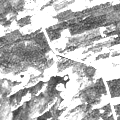

In [85]:
np.array(img_list[1]).shape
img_list[1].show()

In [28]:
get_first_n_pcs(resized, 3).shape

(120, 120, 3)